## Importing swe-BERT for initial training

In [6]:
import torch
import numpy as np
import math
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)
# collab command to install transformers
!pip install transformers
!pip install tqdm


cuda
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [30]:
from torch.utils.data import Dataset


import re
def clean_txt (text):
  text = re.sub("¹", "", text)
  text=re.sub("(\\W)+","  ", text)
  return text


class SNLIDataset(Dataset):

    def __init__(self, filename, max_size=None):
        super().__init__()
        self.xs = []
        self.ys = []
        self.sentence_lengths = np.array([])
        count = 0
        with open(filename, encoding="utf-8") as source:
            for i, line in enumerate(source):
                if i == 0:
                  continue
                # print(line)
                if max_size and i >= max_size:
                    break
                try:
                  sentence, sentiment_value = line.rstrip().split('|') # Delimeter to be chosen
                  count += 1
                except:
                  print( "Error when processing the following data ", [line.rstrip().split('|')])
                # print(sentence)
                self.xs.append(clean_txt(sentence))
                self.ys.append(int(sentiment_value)) # make sure negative/neutral/positive is labelled correct
                self.sentence_lengths = np.append(self.sentence_lengths, len(sentence.split(" ")))

    def __getitem__(self, idx):
        return self.xs[idx], self.ys[idx]

    def __len__(self):
        return len(self.xs)

class SNLIDataset_shell_class(SNLIDataset):
    def __init__(self, xs, ys, sentence_lengths):
      self.xs = xs
      self.ys = ys
      self.sentence_lengths = sentence_lengths

In [29]:
def divide_dataset_to_train_and_test(SNLIDataset, percentage_to_train):
    random_indices = torch.randperm(len(SNLIDataset.xs))
    num_of_sent_in_train = math.floor(len(SNLIDataset.xs)*(percentage_to_train))
 
    train_dataset_xs = list(map(SNLIDataset.xs.__getitem__, random_indices[0:num_of_sent_in_train]))
    train_dataset_ys = list(map(SNLIDataset.ys.__getitem__, random_indices[0:num_of_sent_in_train]))
    train_dataset_sent_lengths = list(map(SNLIDataset.sentence_lengths.__getitem__, random_indices[0:num_of_sent_in_train]))


    test_dataset_xs = list(map(SNLIDataset.xs.__getitem__, random_indices[num_of_sent_in_train:]))
    test_dataset_ys = list(map(SNLIDataset.ys.__getitem__, random_indices[num_of_sent_in_train:]))
    test_dataset_sent_lengths = list(map(SNLIDataset.sentence_lengths.__getitem__, random_indices[num_of_sent_in_train:]))
  
    train_dataset = SNLIDataset_shell_class(train_dataset_xs, train_dataset_ys, train_dataset_sent_lengths)

    test_dataset = SNLIDataset_shell_class(test_dataset_xs, test_dataset_ys, test_dataset_sent_lengths)
    

    return train_dataset, test_dataset



## Create all datasets

In [31]:
# financial_news_train_dataset = SNLIDataset('./Financial Data/financial_phrases_labeled_psv_train.csv')
# financial_news_test_dataset = SNLIDataset('./Financial Data/financial_phrases_labeled_psv_test.csv')
amazon_review_dataset = SNLIDataset('./amazon-review-data/amazon_review_data_psv.csv')
# hp_n, mp_n, neg_n, neu_n = SNLIDataset('./sweOnlyProcData/highPosNews.txt'), SNLIDataset('./sweOnlyProcData/mediumPosNews.txt'), SNLIDataset('./sweOnlyProcData/negativeNews.txt'), SNLIDataset('./sweOnlyProcData/neutralNews.txt')

# data = financial_news_train_dataset[121]

train, test = divide_dataset_to_train_and_test(amazon_review_dataset, 0.9)

print(len(amazon_review_dataset))
print(len(train))
print(len(test))


27000
tensor([ 9268,  7576, 18391,  ...,  6731, 25463, 24912])
30000
27000
3000


## Dataset analysis
Here we analyze the length distribution for each dataset

NameError: ignored

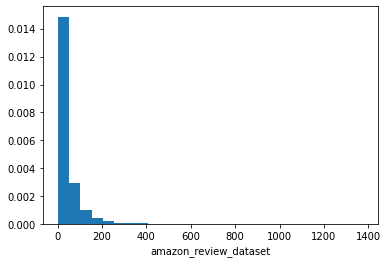

In [ ]:
import matplotlib.pyplot as plt

def plot_data_length(sentence_lengths, datasetName, resolution=1):
    plot_data_length.total_plots += 1
    plt.figure(plot_data_length.total_plots)
    plt.hist(sentence_lengths, bins=int(np.max(sentence_lengths)*resolution), density=True)
    plt.xlabel(datasetName)
plot_data_length.total_plots = 0
plot_data_length(amazon_review_dataset.sentence_lengths, "amazon_review_dataset", 1/50)
plot_data_length(np.concatenate([financial_news_test_dataset.sentence_lengths, financial_news_train_dataset.sentence_lengths]), "financial_news_dataset", 1/4)
plot_data_length(np.concatenate([hp_n.sentence_lengths, mp_n.sentence_lengths, neg_n.sentence_lengths, neu_n.sentence_lengths]), "Own-collected-news", 1/500)


## Import swedish bert

In [ ]:
!pip install transformers
from transformers import BertTokenizer, BertForSequenceClassification, BertModel
from transformers.modeling_outputs import BaseModelOutputWithPooling

tokenizer = BertTokenizer.from_pretrained('KB/bert-base-swedish-cased', do_lower_case=True)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
tokenized = tokenizer(text=financial_news_train_dataset[1][0], padding='longest', return_tensors='pt')
print(financial_news_train_dataset[1][0])
print(tokenized.input_ids)
print(tokenized)

NameError: ignored

### Define colate function that tokenizes

In [ ]:
def get_split(text1):
  l_total = []
  l_parcial = []
  if text1.shape[0]//150 >0:
    n = text1.shape[0]//150
  else: 
    n = 1
  for w in range(n):
    if w == 0:
      l_parcial = text1[:200]
      l_total.append(l_parcial)
    else:
      l_parcial = text1[w*150:w*150 + 200]
      l_total.append(l_parcial)
  return l_total

In [ ]:
def tensor_split(text1, seq_size=200, overlap=50, add_to_start = 2):
  l_total = []
  l_parcial = []
  cls_tokens = torch.unsqueeze(torch.as_tensor([add_to_start]* text1.shape[0]), dim=1)
  if text1.shape[1]//(seq_size-overlap) >0:
    n = text1.shape[1]//(seq_size-overlap)
  else: 
    n = 1
  for w in range(n):
    if w == 0:
      l_parcial = torch.concat([cls_tokens, text1[:,:seq_size]], dim=1)
      l_total.append(l_parcial.to(device))
    else:
      l_parcial = torch.concat([cls_tokens, text1[:,w*(seq_size-overlap):w*(seq_size-overlap) + seq_size]], dim=1)
      l_total.append(l_parcial.to(device))
  return l_total





In [ ]:
def our_collate_fn(data):
    x = [a[0] for a in data]
    y = [a[1] for a in data]
    tokenized = tokenizer(text=x, padding='longest', return_tensors='pt')

    return tokenized['input_ids'], torch.as_tensor(y), tokenized['attention_mask']

In [ ]:
from torch.utils.data import DataLoader

def create_training_examples(dataset, batch_size = 64, seq_size = 200, overlap = 50):
    batch_sort_order = np.array_split(dataset.sentence_lengths.argsort()[::-1], round(len(dataset) / batch_size))
    tokenized_train_data = DataLoader(dataset, collate_fn=our_collate_fn, batch_sampler=batch_sort_order) #

    for bindex, (bx, by, ba) in enumerate(tokenized_train_data):
        yield tensor_split(bx, seq_size, overlap), tensor_split(ba, seq_size, overlap, add_to_start=1), by.to(device)
                




In [ ]:
import torch.nn as nn

rnn = nn.LSTM(10, 20, batch_first = True)
input = torch.randn(3, 5, 10)
h0 = torch.randn(1, 3, 20)
c0 = torch.randn(1, 3, 20)
output, (hn, cn) = rnn(input, (h0, c0))

print("Input shape: {}".format([*input.shape]))
print("Output shape: {}".format([*output.shape]))
print("Last hidden state shape: {}".format([*hn.shape]))

Input shape: [3, 5, 10]
Output shape: [3, 5, 20]
Last hidden state shape: [1, 3, 20]


In [ ]:
import torch.nn as nn


class DocBert(nn.Module):
    def __init__(self, bert, hidden_dim, num_labels):
        super().__init__()
        self.bert =  bert.to(device) # INTE BertForSequenceClassification
        self.lstm = nn.LSTM(bert.config.hidden_size, hidden_dim, batch_first=True).to(device)
        # Input [Batch_size, sequence_length, input_size]
        # Output [1, batch_size, hidden_dim]
        self.linear = nn.Linear(hidden_dim, num_labels).to(device)
    def forward(self, x_seqs, a_seqs):
      output = []
      for x_seq, a_seq in zip(x_seqs, a_seqs):
        output.append(self.bert(x_seq, a_seq).pooler_output)#Only get the embedding of the [CLS]-token [batch_size, number_of_sequences, input_size]
      _ , (output, _) = self.lstm(torch.stack(output, dim=1)) # [1, batch_size, hidden_dim]
      return self.linear(torch.squeeze(output, dim=0))
      #   bertified_seqs.append()
      # self.lstm(, )

    def predict(self, ):
      pass


bert = BertModel.from_pretrained('KB/bert-base-swedish-cased')
docbert = DocBert(bert, 20, 3)

Some weights of the model checkpoint at KB/bert-base-swedish-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


#### Functions for training and testing a model

In [ ]:
import torch.nn.functional as F
optimizer = torch.optim.Adam(docbert.parameters())
i = 0
tot_loss = 0
for x_seqs, a_seqs, by in create_training_examples(amazon_review_dataset, batch_size=8, seq_size=200, overlap=50):
  optimizer.zero_grad()
  preds = docbert.forward(x_seqs, a_seqs)
  loss = F.cross_entropy(preds, by)
  tot_loss += loss
  i += 1
  if i % 10 == 0:
    print(tot_loss / 10)
    tot_loss = 0
  loss.backward()
  optimizer.step()



tensor(0.9039, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.9450, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.8272, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.5149, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.7695, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.6490, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.5910, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.6536, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.6638, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.8022, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.5263, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.7647, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.6702, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.7112, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.5165, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.8808, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.6967, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.7046, device='cuda:0', grad_fn=<DivBack

In [ ]:
from torch.utils.data import DataLoader
from tqdm import tqdm
def train_model(train_data, batch_size):
  batch_sort_order = np.array_split(train_data.sentence_lengths.argsort()[::-1], round(len(train_data) / batch_size))
  tokenized_train_data = DataLoader(train_data, collate_fn=our_collate_fn, batch_sampler=batch_sort_order) #
  
  # print(tokenized_train_data)
  # for batch in tokenized_train_data:
  #     for sent_pair in batch[0]:
  #       print(sent_pair)
  #     print(batch)
  #     break
  

  model = BertForSequenceClassification.from_pretrained('KB/bert-base-swedish-cased', num_labels=3)
  model = model.to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
  # softmax = torch.nn.Softmax(dim=1)
  epochs = 1

  for _ in range(epochs):
    model.train()

    with tqdm(total=len(train_data)) as pbar:

      for bindex, (bx, by, ba) in enumerate(tokenized_train_data):
        bx, by, ba = bx.to(device), by.to(device), ba.to(device)
        optimizer.zero_grad()
        # forward pass
        train_output = model(bx, labels=by, attention_mask=ba)
        # backward pass
        train_output.loss.backward()
        optimizer.step()
        pbar.update(len(bx))
  return model

def evaluate_model(model, valid_data, batch_size):
    batch_sort_order = np.array_split(valid_data.sentence_lengths.argsort()[::-1], round(len(valid_data) / batch_size))
    tokenized_valid_data = DataLoader(valid_data, batch_sampler=batch_sort_order, collate_fn=our_collate_fn)
    model.eval()
    valids = []
    for bx, by, ba in tokenized_valid_data:
      with torch.no_grad():
        bx, by, ba = bx.to(device), by.to(device), ba.to(device)
        # forward pass
        try:
          eval_output = model(bx, attention_mask=ba)
          guess = torch.argmax(eval_output.logits, dim=1)
          valids.append(sum(guess == by)/len(by))
        except Exception as e:
          print(bx.shape, by.shape)
          print(ba.shape)
          print(e)
        
    print('Accuracy: {}'.format(sum(valids)/len(valids)))


## Train and save the financial model

In [ ]:
financial_trained_model = train_model(financial_news_train_dataset, 64)
evaluate_model(financial_trained_model, financial_news_test_dataset)
financial_trained_model.save_pretrained("./financial_trained_model")

KeyboardInterrupt: ignored

## Load the financial model and evaluate it on similar test-data 
accuracy should be 88%+

In [ ]:
loadedModel = BertForSequenceClassification.from_pretrained("./financial_trained_model/")
evaluate_model(loadedModel, financial_news_test_dataset, 32)

Accuracy: 0.8862680196762085


In [ ]:
evaluate_model(loadedModel, amazon_review_dataset, 16)

Accuracy: 0.39497217535972595
